# 1. Overview

The code here implements a fully-connected feedforward network from scratch. It is based on material covered in the *DeepLearning.AI* [Deep Learning Specialization](https://www.deeplearning.ai/courses/deep-learning-specialization/), and is loosely inspired by the `Keras` neural network implementation for the coding architecture.

Capabilities implemented so far:

* Layer types:
    * Dense (only layer type supported so far)
        * Weight initializations:
            1. Xavier
            2. He
* Activation functions:
    * ReLU
    * Leaky ReLU
    * Tanh
    * Sigmoid
    * Linear (identity)
* Loss functions and evaluation metrics:
    * Binary cross-entropy (both)
    * Mean squared error (both)
    * Accuracy (only as an evaluation metric)
* Regularization methods:
    * L2
    * Dropout
    * Early stopping
* Optimization:
    * Mini-batches
    * Momentum
    * RMSprop
    * Adam
    * Learning rate decay
* Evaluation on a validation set supported
* A gradient-checking function to verify the validity of the gradient descent implementation

# 2. Model Construction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy
from abc import ABC, abstractmethod

In [2]:
# --------------------------------------------
class Activations:
    class relu:
        @staticmethod
        def activate(x):
            return np.maximum(x, 0)
        @staticmethod
        def derivative(x):
            return np.where(x >= 0, 1, 0)
    class leakyrelu:
        @staticmethod
        def activate(x):
            return np.where(x >= 0, x, 0.01*x)
        @staticmethod
        def derivative(x):
            return np.where(x >= 0, 1, 0.01)
    class sigmoid:
        @staticmethod
        def activate(x):
            return 1 / (1 + np.exp(-x))
        @staticmethod
        def derivative(x):
            return Activations.sigmoid.activate(x) * (1 - Activations.sigmoid.activate(x))
    class tanh:
        @staticmethod
        @np.vectorize
        def activate(x):
            return np.math.tanh(x)
        @staticmethod
        @np.vectorize
        def derivative(x):
            return 1 - np.math.tanh(x) ** 2
    class linear:
        @staticmethod
        def activate(x):
            return x
        @staticmethod
        def derivative(x):
            return 1

# --------------------------------------------
class Dense:
    
    def __init__(self,  shape, activation = 'linear', weight_initialization = None, dropout = 0.0):
        self.nl = shape[0]
        self.activation = getattr(Activations, activation)
        self.nl_1 = shape[1]
        self.dropout = dropout
        
        if weight_initialization in ['Xavier', 'He']:
            self.weight_initialization = weight_initialization
        elif weight_initialization is None:
            self.weight_initialization = self._set_default_initializer(activation)
        else:
            raise ValueError('Initialization method not supported')
        
        if self.weight_initialization == 'Xavier':
            self.W = self._Xavier_initialization(self.nl, self.nl_1)
        elif self.weight_initialization == 'He':
            self.W = self._He_initialization(self.nl, self.nl_1)
        self.b = np.zeros(self.nl).reshape(self.nl, 1)
        
        self.VdW = np.zeros_like(self.W)
        self.Vdb = np.zeros_like(self.b)
        self.SdW = np.zeros_like(self.W)
        self.Sdb = np.zeros_like(self.b)
    
    def _set_default_initializer(self, activation):
        if activation in ['relu', 'leakyrelu']:
            return 'He'
        else:
            return 'Xavier'
    
    def _Xavier_initialization(self, nl, nl_1):
        bound = (6 / (nl + nl_1)) ** 0.5
        return np.random.uniform(-bound, bound, size = (nl, nl_1))
    
    def _He_initialization(self, nl, nl_1):
        stdev = (2 / nl_1) ** 0.5
        return np.random.normal(scale = stdev, size = (nl, nl_1))

# --------------------------------------------
class Metrics:
    @staticmethod
    def accuracy(y, preds, threshold = 0.5):
        return (np.mean((preds >= threshold) - y == 0))
    @staticmethod
    def binary_crossentropy(y, preds):
        return -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))
    @staticmethod
    def mean_squared_error(y, preds):
        return ((y - preds) ** 2).mean()

# --------------------------------------------
class Optimizers(ABC):
    def __init__(self):
        super().__init__()
    @abstractmethod
    def _update_accumulators(self, layer):
        pass
    @abstractmethod
    def _gen_update_quantity(self, layer, attr, num_iterations):
        pass

class GradientDescent(Optimizers):
    def __init__(self, momentum = 0.9):
        self.momentum = momentum
    def _update_accumulators(self, layer):
        layer.VdW = self.momentum * layer.VdW + (1 - self.momentum) * layer.dW
        layer.Vdb = self.momentum * layer.Vdb + (1 - self.momentum) * layer.db
    def _gen_update_quantity(self, layer, attr, num_iterations):
        if attr == 'W':
            return layer.VdW
        if attr == 'b':
            return layer.Vdb
class RMSprop(Optimizers):
    def __init__(self, beta = 0.999, epsilon = 1e-8):
        self.beta = beta
        self.epsilon = epsilon
    def _update_accumulators(self, layer):
        layer.SdW = self.beta * layer.SdW + (1 - self.beta) * layer.dW**2
        layer.Sdb = self.beta * layer.Sdb + (1 - self.beta) * layer.db**2
    def _gen_update_quantity(self, layer, attr, num_iterations):
        if attr == 'W':
            return layer.dW / (layer.SdW ** .5 + self.epsilon)
        if attr == 'b':
            return layer.db / (layer.Sdb ** .5 + self.epsilon)
class Adam(Optimizers):
    def __init__(self, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8):
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
    def _update_accumulators(self, layer):
        layer.VdW = self.beta_1 * layer.VdW + (1 - self.beta_1) * layer.dW
        layer.Vdb = self.beta_1 * layer.Vdb + (1 - self.beta_1) * layer.db
        layer.SdW = self.beta_2 * layer.SdW + (1 - self.beta_2) * layer.dW**2
        layer.Sdb = self.beta_2 * layer.Sdb + (1 - self.beta_2) * layer.db**2
    def _gen_update_quantity(self, layer, attr, num_iterations):
        if attr == 'W':
            VdW_corrected = layer.VdW / (1 - self.beta_1 ** num_iterations)
            SdW_corrected = layer.SdW / (1 - self.beta_2 ** num_iterations)
            return VdW_corrected / (SdW_corrected ** .5 + self.epsilon)
        if attr == 'b':
            Vdb_corrected = layer.Vdb / (1 - self.beta_1 ** num_iterations)
            Sdb_corrected = layer.Sdb / (1 - self.beta_2 ** num_iterations)
            return Vdb_corrected / (Sdb_corrected ** .5 + self.epsilon)

In [3]:
class MLP:
    
    def __init__(self, loss = 'binary_crossentropy', metric = 'accuracy', restore_best = True, l2_reg = 0.0,
                 input_dropout = 0.0, input_normalization = True):
        self.layers = []
        self.loss = loss
        self.metric = metric
        self.restore_best = restore_best
        self.l2_reg = l2_reg
        self.input_dropout = input_dropout
        self.input_normalization = input_normalization
        if loss not in ['binary_crossentropy', 'mean_squared_error']:
            raise ValueError('Loss not currently supported')
        if metric not in ['accuracy', 'binary_crossentropy', 'mean_squared_error']:
            raise ValueError('Metric not currently supported')
    
    def add(self, layer):
        self.layers.append(layer)
    
    def fit(self, X, y, epochs = 100, batch_size = 32, earlyStopping = None, validation_split = 0.0,
            lr = 0.01, decay_rate = 1, optimizer = Adam()):
        
        self.validation_split = validation_split
        X_train, X_dev, y_train, y_dev = self._custom_train_test_split(X, y, validation_split)
        
        if self.input_normalization is True:
            self.normalizer = StandardScaler().fit(X_train)
        
        self.optimizer = optimizer
        self.history = self._History()
        self.epochs = 0
        self.stopper = 0  # increment until the early stopping value
        
        for i in range(epochs):
            self._minibatch_gradientdescent(X, y, batch_size, lr, decay_rate)
            self.epochs += 1
            self.history.train_score.append(self.score(X_train, y_train))
            if validation_split > 0:
                self.history.dev_score.append(self.score(X_dev, y_dev))
            
            self._check_earlyStopping()
            if self.restore_best == True:
                self._cache_best()
            if earlyStopping is not None:
                if self.stopper == earlyStopping:
                    break
                    
        del self.stopper
        if self.restore_best is True:
            self._restore_best_weights()
    
    def predict(self, X):
        self._forwardprop(X, training = False)
        preds = self.layers[-1].A
        return preds
    
    def score(self, X, y):
        preds = self.predict(X)
        score_fn = getattr(Metrics, self.metric)
        return score_fn(y, preds)
    
    def _custom_train_test_split(self, X, y, validation_split):
        if validation_split < 0 or validation_split >= 1:
            raise ValueError('Validation split should be in the range [0,1) (0 results in no validation set)')
        indices = np.random.permutation(len(X))
        train_size = round(len(X) * (1 - validation_split))
        self.train_indices = indices[:train_size]
        X_train = X[self.train_indices]
        y_train = y[self.train_indices]
        X_dev = X[indices[train_size:]]
        y_dev = y[indices[train_size:]]
        return X_train, X_dev, y_train, y_dev
    
    def _minibatch_gradientdescent(self, X, y, batch_size, lr, decay_rate):
        num_batches = np.ceil(len(self.train_indices) / batch_size)
        num_iterations = self.epochs * num_batches
        for i in np.arange(0, len(self.train_indices), batch_size):
            num_iterations += 1
            minibatch = self.train_indices[i : (i + batch_size)]
            mini_X, mini_y = X[minibatch], y[minibatch]
            self._forwardprop(mini_X, training = True)
            self._backprop(mini_X, mini_y)
            self._update_params(mini_X.shape[0], lr, decay_rate, num_iterations)
    
    def _forwardprop(self, X, training):
        if self.input_normalization is True:
            X = self.normalizer.transform(X)
        self.layers.insert(0, self._InputLayer(A = X.T, nl = X.shape[1]))
        if training is True:
            inverted_dropout_mask = ((np.random.rand(X.T.shape[0], X.T.shape[1]) > self.input_dropout)
                                           / (1 - self.input_dropout))
            self.layers[0].A *= inverted_dropout_mask
        for l, layer in enumerate(self.layers[1:], start = 1):
            layer.Z = layer.W @ self.layers[l-1].A + layer.b
            layer.A = layer.activation.activate(layer.Z)
            if training is True:
                inverted_dropout_mask = ((np.random.rand(layer.A.shape[0], layer.A.shape[1]) > layer.dropout)
                                               / (1 - layer.dropout))
                layer.A *= inverted_dropout_mask
        self.layers.pop(0)
    
    def _backprop(self, X, y):
        if self.input_normalization is True:
            X = self.normalizer.transform(X)
        self.layers.insert(0, self._InputLayer(A = X.T, nl = X.shape[1]))
        # Output layer's gradients
        yhat = self.layers[-1].A
        if self.loss == 'binary_crossentropy':
            self.layers[-1].dA = -(y/yhat) + (1-y) / (1 - yhat)
        elif self.loss == 'mean_squared_error':
            self.layers[-1].dA = -2 * (y - yhat)
        self.layers[-1].dZ = self.layers[-1].dA * self.layers[-1].activation.derivative(self.layers[-1].Z)
        self.layers[-1].dW = (self.layers[-1].dZ @ self.layers[-2].A.T) / X.shape[0]
        self.layers[-1].db = self.layers[-1].dZ.mean(axis = 1, keepdims = True)
        self.optimizer._update_accumulators(self.layers[-1])
        # Remaining layers' gradients and velocities
        for l, layer in reversed(list(enumerate(self.layers[:-1]))):
            if isinstance(layer, self._InputLayer):
                break
            layer.dA = self.layers[l + 1].W.T @ self.layers[l + 1].dZ
            layer.dZ = layer.dA * layer.activation.derivative(layer.Z)
            layer.dW = (layer.dZ @ self.layers[l-1].A.T) / X.shape[0]
            layer.db = layer.dZ.mean(axis = 1, keepdims = True)
            self.optimizer._update_accumulators(layer)
        self.layers.pop(0)
    
    def _update_params(self, m, lr, decay_rate, num_iterations):
        for layer in self.layers:
            decayed_lr = lr / (1 + decay_rate * (self.epochs+1))
            layer.W -= decayed_lr * (self.optimizer._gen_update_quantity(layer, 'W', num_iterations)
                                     + (self.l2_reg / m) * layer.W)
            layer.b -= decayed_lr * self.optimizer._gen_update_quantity(layer, 'b', num_iterations)
    
    def _check_earlyStopping(self):
        eval_fn = max if self.metric in ['accuracy'] else min
        if self.validation_split > 0:
            if self.history.dev_score[-1] == eval_fn(self.history.dev_score):
                self.stopper = 0
            else:
                self.stopper += 1
        else:
            if self.history.train_score[-1] == eval_fn(self.history.train_score):
                self.stopper = 0
            else:
                self.stopper += 1
    
    def _cache_best(self):
        if self.stopper == 0:
            self.history.best_W = [layer.W for layer in self.layers]
            self.history.best_b = [layer.b for layer in self.layers]
            if self.validation_split > 0:
                self.history.best_score = self.history.dev_score[-1]
            else:
                self.history.best_score = self.history.train_score[-1]
    
    def _restore_best_weights(self):
        for l, layer in enumerate(self.layers):
            layer.W = self.history.best_W[l]
            layer.b = self.history.best_b[l]
    
    class _InputLayer:
        def __init__(self, A, nl):
            self.A = A
            self.nl = nl
    
    class _History:
        def __init__(self, train_score = None, dev_score = None):
            if train_score is None:
                self.train_score = []
            if dev_score is None:
                self.dev_score = []

# 3. Gradient Checking

In [4]:
def J(X, y, model):
    loss_fn = getattr(Metrics, model.loss)
    yhat = model.predict(X)
    base_loss = loss_fn(y, yhat)
    reg_loss = sum([(layer.W**2).sum() for layer in model.layers]) * (model.l2_reg / (2*X.shape[0]))
    return base_loss + reg_loss

def gradient_approx(X, y, model, l, attr, index, epsilon=1e-7):
    tmp_model = copy.deepcopy(model)
    getattr(tmp_model.layers[l], attr)[index] += epsilon
    J1 = J(X, y, tmp_model)
    getattr(tmp_model.layers[l], attr)[index] -= 2*epsilon
    J2 = J(X, y, tmp_model)
    return (J1 - J2) / (2*epsilon)

def gradient_checking(X, y, model):
    results = []
    
    model._forwardprop(X, training = False)
    model._backprop(X, y)
    
    for l, layer in enumerate(model.layers):
        for index, dw in np.ndenumerate(layer.dW):
            approximation = gradient_approx(X, y, model, l, 'W', index)
            results.append([l,
                            'W',
                            index,
                            dw + layer.W[index] * (model.l2_reg / X.shape[0]),
                            approximation])

        for index, db in np.ndenumerate(layer.db):
            approximation = gradient_approx(X, y, model, l, 'b', index)
            results.append([l, 'b', index, db, approximation])

    results = pd.DataFrame(results, columns = ['Layer', 'Attr', 'Index', 'dtheta', 'dtheta_approx'])
    results['Difference'] = results['dtheta'] - results['dtheta_approx']
    
    normalized_distance = (np.linalg.norm(results['dtheta'] - results['dtheta_approx'])
                            / (np.linalg.norm(results['dtheta']) + np.linalg.norm(results['dtheta_approx'])))
    
    return normalized_distance

# 4. Classification and Regression Implementations

### Classification

In [5]:
X, y = make_classification(
    n_samples=1000,   # Number of samples
    n_features=80,    # Number of features
    n_informative=50, # Number of informative features
    n_redundant=30,   # Number of redundant features
    n_classes=2,      # Number of classes
    random_state=42   # Random seed for reproducibility
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)

In [6]:
model = MLP(l2_reg = 0.5, input_dropout=0.1)
model.add(Dense((32, 80), 'relu', dropout=0.1))
model.add(Dense((16, 32), 'leakyrelu', dropout=0.0))
model.add(Dense((4, 16), 'tanh', dropout=0.0))
model.add(Dense((1, 4), 'sigmoid'))

model.fit(X_train, y_train,
          epochs=1000,
          earlyStopping=20,
          validation_split = 1/9,
          lr = 0.005)
model.epochs

314

In [7]:
print('Train score:', round(max(model.history.train_score), 3))
print('Dev score:  ', model.history.best_score)
print('Test score: ', model.score(X_test, y_test))

Train score: 0.99
Dev score:   0.93
Test score:  0.93


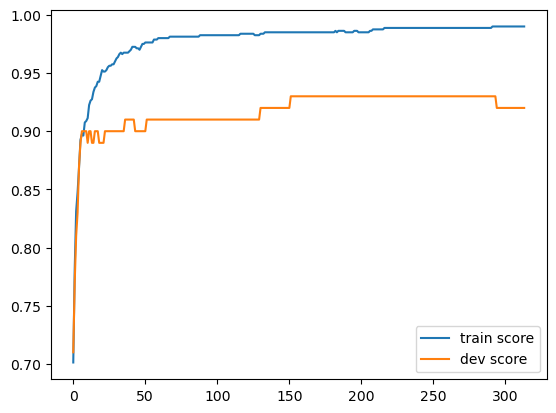

In [8]:
plt.plot(range(len(model.history.train_score)), model.history.train_score, label = 'train score')
plt.plot(range(len(model.history.dev_score)), model.history.dev_score, label = 'dev score')
plt.legend()
plt.show()

In [9]:
gradient_checking(X_train, y_train, model)

1.847958274328921e-08

### Regression

In [10]:
X, y = make_regression(
    n_samples=1000,   # Number of samples
    n_features=80,    # Number of features
    n_informative=50, # Number of informative features
    noise=0.1,        # SD of the gaussian noise applied to the output
    random_state=42   # Random seed for reproducibility
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)

In [11]:
model = MLP(l2_reg = 0.5, input_dropout=0.1, loss = 'mean_squared_error', metric = 'mean_squared_error')
model.add(Dense((32, 80), 'relu', dropout=0.1))
model.add(Dense((16, 32), 'leakyrelu', dropout=0.0))
model.add(Dense((4, 16), 'leakyrelu', dropout=0.0))
model.add(Dense((1, 4)))

model.fit(X_train, y_train,
          epochs=1000,
          earlyStopping=20,
          validation_split = 1/9,
          lr = 1e-2)
len(model.history.dev_score)

158

In [12]:
print('Train score:', round(min(model.history.train_score), 3))
print('Dev score:  ', model.history.best_score)
print('Test score: ', model.score(X_test, y_test))

Train score: 2706.752
Dev score:   4308.430976628335
Test score:  4966.848037979158


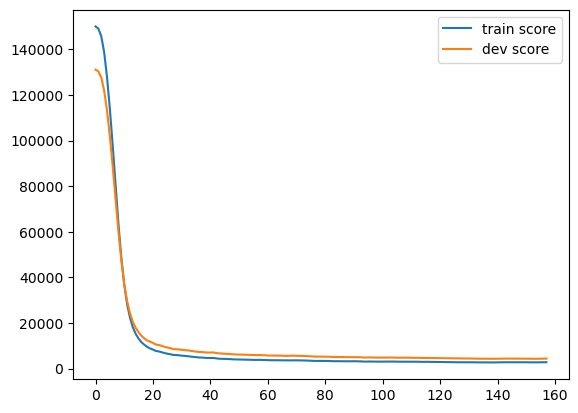

In [13]:
plt.plot(range(len(model.history.train_score)), model.history.train_score, label = 'train score')
plt.plot(range(len(model.history.dev_score)), model.history.dev_score, label = 'dev score')
plt.legend()
plt.show()

In [14]:
gradient_checking(X_train, y_train, model)

4.045433751244339e-09

# Notes/Drafts

Hyperparameters:
* learning rate $\alpha$
* number of iterations
* number of hidden layers L
* number of hidden units $n^{[1]}, ..., n^{[L]}$
* activation function choices
* loss function
* regularization:
    * L2
    * dropout
    * early stopping
    * data augmentation

Others yet to implement:
* momentum
* minibatch size
* learning rate decay

Lower down in importance but can potentially tune:
* standard deviation of weight initializations